<a href="https://colab.research.google.com/github/erd3muysal/gender_classification/blob/main/gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and Extract Data

In [ ]:
# Download data
!curl -O http://www.openslr.org/resources/12/dev-clean.tar.gz

In [ ]:
# Extract data
!tar -xvzf dev-clean.tar.gz

# Exploratory Data Analysis

## Import Necessary Packages

In [208]:
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data operations
import matplotlib.pyplot as plt  # Library for visualization
import seaborn as sns  # Library for visualization
import os
import librosa  # Library for processing audio data
import librosa.display
import IPython.display as ipd  # Library for playing sound in the notebook
from tqdm import tqdm_notebook  # Library for process bar

np.random.seed(42)
%matplotlib inline
plt.style.use('ggplot')

In [209]:
ROOT = '/content'  # Root directory
BASE = '/LibriSpeech/dev-clean'  # Dataset directory

## Understanding Data

Before creating Deep Learning model, lets dive into dataset and see what kind of data included in our dataset in order to get better understanding of task.

In [210]:
# List speaker ids into a variable
speaker_idx = os.listdir(ROOT + BASE)
# Find and then sort all unique speakers in the list
speaker_idx = sorted(speaker_idx)
print(speaker_idx)
print()
print("There are", len(speaker_idx), "unique speakers in the dataset.")

['1272', '1462', '1673', '174', '1919', '1988', '1993', '2035', '2078', '2086', '2277', '2412', '2428', '251', '2803', '2902', '3000', '3081', '3170', '3536', '3576', '3752', '3853', '422', '5338', '5536', '5694', '5895', '6241', '6295', '6313', '6319', '6345', '652', '777', '7850', '7976', '8297', '84', '8842']

There are 40 unique speakers in the dataset.


SPEAKERS.TXT file contains all of the meta data about the speakers. However it also has some unnecessary lines that contains some explonations about the data. With these unnecessary lines, we are not able to create an apropriate dataframe for our project. For creating an apropriate dataframe, we should skip those lines.

In [211]:
# Create a meta dataframe from 'SPEAKERS.TXT' file by skipping first 11 lines of and seperating w.r.t. '|'  
meta_df = pd.read_csv('/content/LibriSpeech/SPEAKERS.TXT', skiprows=11, sep='|', error_bad_lines=False)
# Convert column names to lowercase
meta_df.columns = [col.strip().replace(';', '').lower() for col in meta_df.columns]  # Columns: 'id', 'sex', 'subset', 'minutes', 'name'
# Print first 5 lines of the dataframe
meta_df.head()

b'Skipping line 45: expected 5 fields, saw 7\n'


,id,sex,subset,minutes,name
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine


In [213]:
fnames = []  # File names storage
paths = []  # File paths storage
number_of_recordings = []

for speaker in os.listdir(ROOT + BASE):  # Traverse in speaker folders
  for book in os.listdir(ROOT + BASE + '/' + speaker):  # Traverse in book folders
    for record in os.listdir(ROOT + BASE + '/' + speaker + '/' + book):  # Traverse in record files
      if not record.endswith(".txt"):  # If file extension is not '.txt'
        fnames.append(record)  # Append each record into 'fnames'
        paths.append(ROOT + BASE + '/' + speaker + '/' + book + '/' + record)  # Append each record's path into 'paths'

# Sort 'fnames' and 'paths' for put them in same order in order to match file name with its path
fnames = sorted(fnames)  # Sort 'fnames'
paths = sorted(paths)  # Sort 'paths'
number_of_recordings = len(fnames)

In [214]:
print("There are", number_of_recordings, "unique speech recordings in the dataset.")

There are 2703 unique speech recordings in the dataset.


In [215]:
def get_id(fname):
  """
  A function to get speaker id from file name.

  Arguments:
  fname -- File name string

  Return:
  fname.split('-')[0] -- First element after seperation
  """
  return fname.split('-')[0]

In [216]:
def get_label(df, index):
  """
  A function to get label from speaker id.

  Arguments:
  df -- Dataframe that stores label information
  index -- Index of the file name whose label will be extracted

  Return:
  sub_df.iloc[0] -- Label that corresponds to indicated speaker id
  """
  sub_df = df.loc[df['id'] == int(get_id(fnames[index]))]['sex']
  return sub_df.iloc[0]

Let's see some examples to see if functions that we created above work properly.

In [217]:
print("File name: ", fnames[0])
print()
print("Path of the file: ", paths[0])
print()
print("Id of the speaker: ", get_id(fnames[0]))
print()
print("Label of the record: ", get_label(meta_df, 0))

File name:  1272-128104-0000.flac

Path of the file:  /content/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac

Id of the speaker:  1272

Label of the record:   M 


In [218]:
print("File name: ", fnames[2000])
print()
print("Path of the file: ", paths[2000])
print()
print("Id of the speaker: ", get_id(fnames[2000]))
print()
print("Label of the record: ", get_label(meta_df, 2000))

File name:  6313-66125-0023.flac

Path of the file:  /content/LibriSpeech/dev-clean/6313/66125/6313-66125-0023.flac

Id of the speaker:  6313

Label of the record:   F 


It is obvious that file names, their paths, their corresponding ids and labels are matching with each other.

## Examples from Dataset

Let's first listen some examples from our dataset and then visualize their spectrograms and wave plots. 

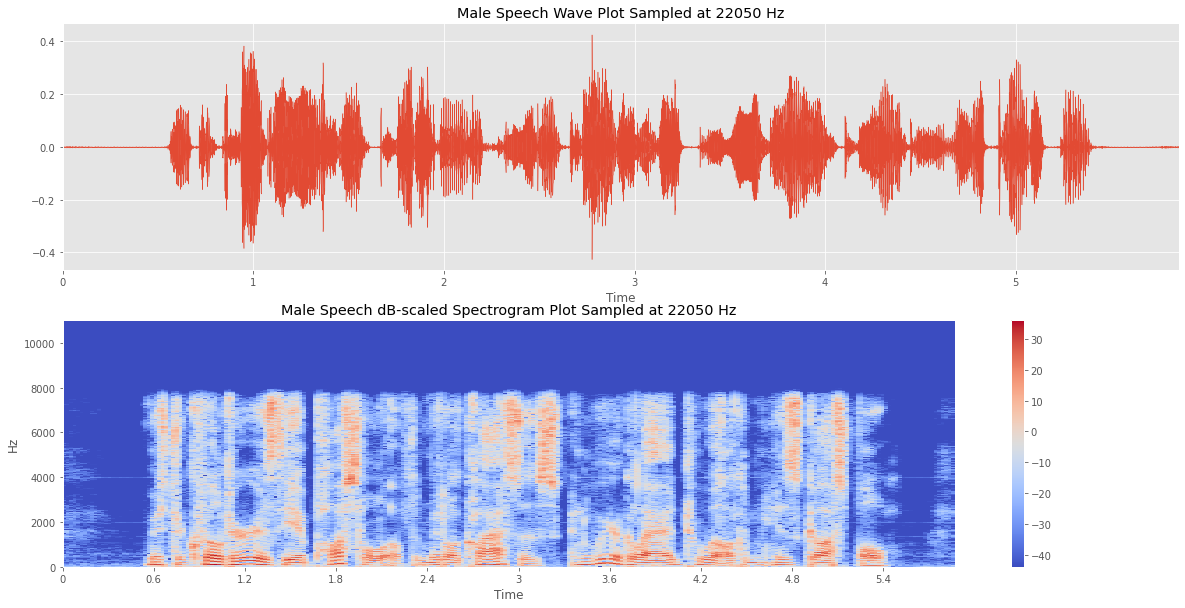

In [219]:
# Load speech recording
data, sampling_rate = librosa.load(paths[0])
# Short Time Fourier Transform
data_stft = librosa.stft(data)
# Covert amplitude to db
data_db = librosa.amplitude_to_db(abs(data_stft))

# Create a figure and set figure size
plt.figure(figsize=(20, 10))  

# Plot wave diagram
plt.subplot(211)  # Create subplot
plt.title("{} Wave Plot Sampled at {} Hz".format('Female Speech' if get_label(meta_df, 0) == ' F ' else 'Male Speech', sampling_rate))  # Add title
librosa.display.waveplot(data, sr=sampling_rate)  # Show plot

plt.subplot(212)  # Create subplot
plt.title("{} dB-scaled Spectrogram Plot Sampled at {} Hz".format('Female Speech' if get_label(meta_df, 0) == ' F ' else 'Male Speech', sampling_rate))  # Add title
plt.xlabel("Time [sec]")  # Add x-axis
plt.ylabel("Frequency [Hz]")  # Add y-axis
librosa.display.specshow(data_db, sr=sampling_rate, x_axis='time', y_axis='hz')  # Show plot
plt.colorbar()

# Play recording
ipd.Audio(paths[0])

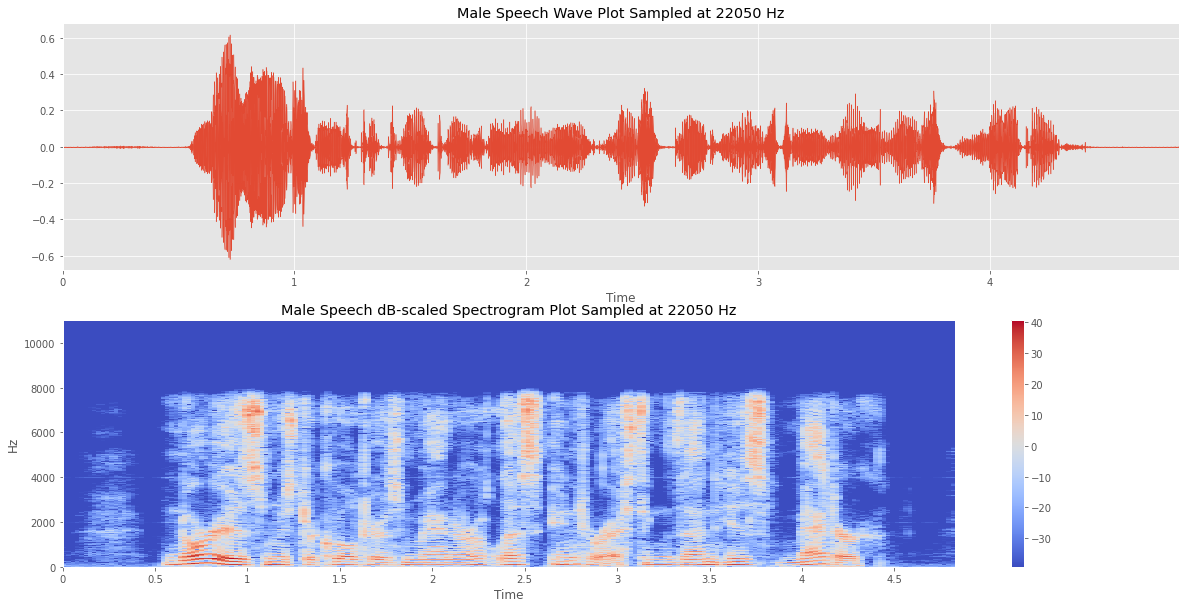

In [220]:
# Load speech recording
data, sampling_rate = librosa.load(paths[1])
# Short Time Fourier Transform
data_stft = librosa.stft(data)
# Covert amplitıde to db
data_db = librosa.amplitude_to_db(abs(data_stft))

# Create a figure and set figure size
plt.figure(figsize=(20, 10))  

# Plot wave diagram
plt.subplot(211)  # Create subplot
plt.title("{} Wave Plot Sampled at {} Hz".format('Female Speech' if get_label(meta_df, 1) == ' F ' else 'Male Speech', sampling_rate))  # Add title
librosa.display.waveplot(data, sr=sampling_rate)  # Show plot

plt.subplot(212)  # Create subplot
plt.title("{} dB-scaled Spectrogram Plot Sampled at {} Hz".format('Female Speech' if get_label(meta_df, 1) == ' F ' else 'Male Speech', sampling_rate))  # Add title
plt.xlabel("Time [sec]")  # Add x-axis
plt.ylabel("Frequency [Hz]")  # Add y-axis
librosa.display.specshow(data_db, sr=sampling_rate, x_axis='time', y_axis='hz')  # Show plot
plt.colorbar()

# Play recording
ipd.Audio(paths[1])

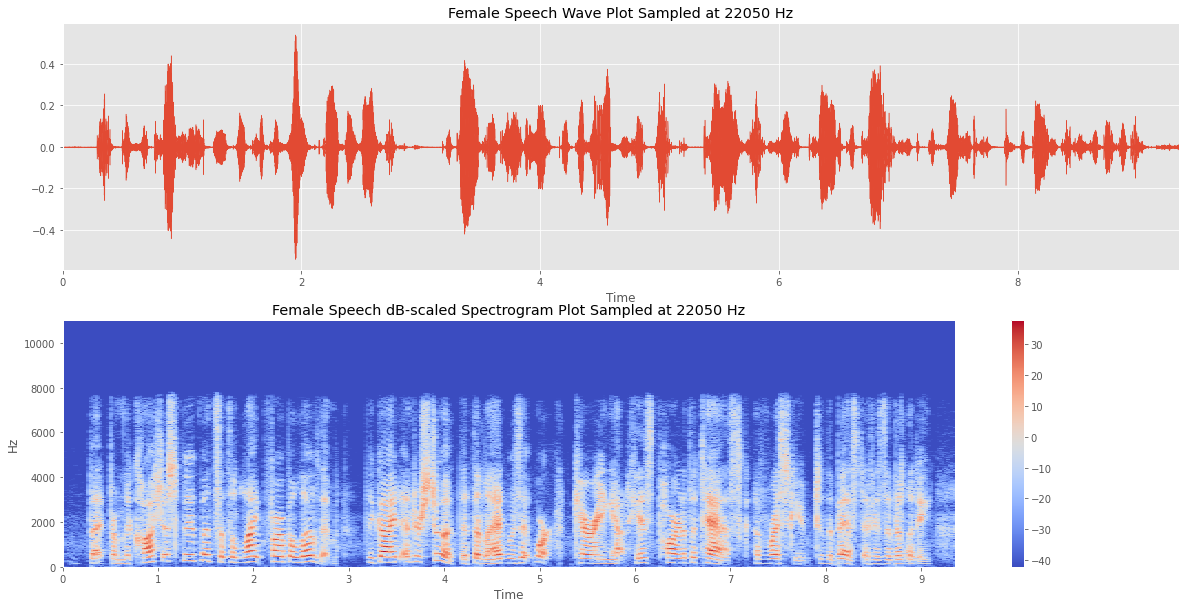

In [221]:
# Load speech recording
data, sampling_rate = librosa.load(paths[2000])
# Short Time Fourier Transform
data_stft = librosa.stft(data)
# Covert amplitıde to db
data_db = librosa.amplitude_to_db(abs(data_stft))

# Create a figure and set figure size
plt.figure(figsize=(20, 10))  

# Plot wave diagram
plt.subplot(211)  # Create subplot
plt.title("{} Wave Plot Sampled at {} Hz".format('Female Speech' if get_label(meta_df, 2000) == ' F ' else 'Male Speech', sampling_rate))  # Add title
librosa.display.waveplot(data, sr=sampling_rate)  # Show plot

plt.subplot(212)  # Create subplot
plt.title("{} dB-scaled Spectrogram Plot Sampled at {} Hz".format('Female Speech' if get_label(meta_df, 2000) == ' F ' else 'Male Speech', sampling_rate))  # Add title
plt.xlabel("Time [sec]")  # Add x-axis
plt.ylabel("Frequency [Hz]")  # Add y-axis
librosa.display.specshow(data_db, sr=sampling_rate, x_axis='time', y_axis='hz')  # Show plot
plt.colorbar()

# Play recording
ipd.Audio(paths[2000])

## Generating MFCCs

In [222]:
def plot_mfcc(file_name, index):
  """
  Plots MFCC features.
  """
  data, sampling_rate = librosa.load(file_name, res_type='kaiser_fast') 
  mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)

  plt.figure(figsize=(20, 5))
  plt.title("MFCC Plot of {}".format('Female Speech' if get_label(meta_df, index) == ' F ' else 'Male Speech'))  # Add title
  plt.xlabel("Time [s]")
  plt.ylabel("MFCC")
  librosa.display.specshow(mfcc, sr=sampling_rate, x_axis='time')
  plt.colorbar();

In [223]:
def extract_features(file_name):
  """
  Extracts MFCC features of audio file.
  """
  try:
    data, sampling_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc.T, axis=0)

  except Exception as e:
    print("Error encountered while parsing file: ", file)
    return None 
   
  return mfcc_scaled

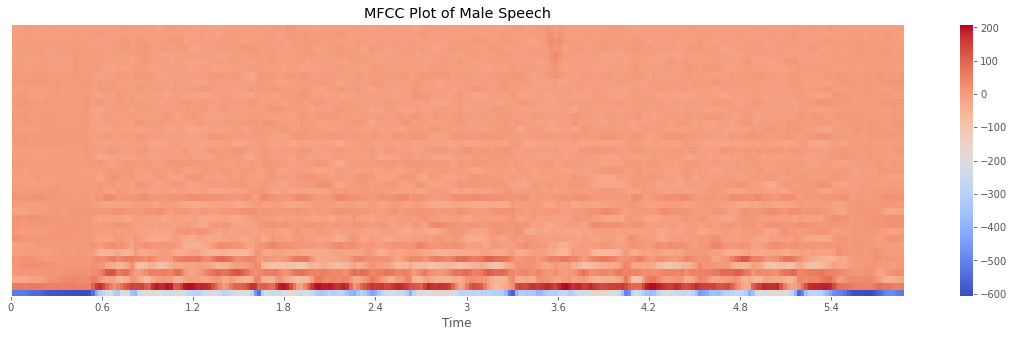

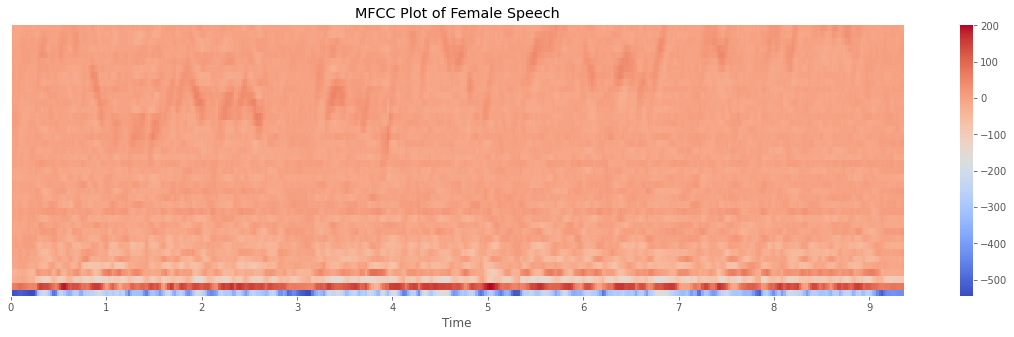

In [224]:
# Plot MFCCs
plot_mfcc(paths[0], 0)
plot_mfcc(paths[2000], 2000)

Since MFCC data gives more information about speeches structure, we want to feed our model with MFCC data instead of raw speech data. For this purpose, we are traversing in our dataset and extracting MFCC features of each speech recordings then insert them into new dataframe. 

In [189]:
# Create a 'feature_df' dataframe for inserting MFCC data
features_df = pd.DataFrame(columns=['feature'])
# Create a 'labels_df' dataframe for inserting target values
labels_df = pd.DataFrame(columns=['target'])

# Loop over the entire dataset for feature extraction
counter = 0
for index, path in enumerate(paths):
    mfcc_scaled = extract_features(path)
  
    # Assign MFCC features into 'features_df' dataframe
    features_df.loc[counter] = [mfcc_scaled]
    # Assign target values into 'labels_df' dataframe
    labels_df.loc[counter] = get_label(meta_df, index)

    counter = counter + 1   

# Concat 'features_df' with 'labels_df'
df = pd.concat([labels_df, pd.DataFrame(features_df['feature'].values.tolist())], axis=1)
# Fill NA entities with 0
df = df.fillna(0)


print("There are", len(df), "speech recordings (samples) in the dataset.")
print("There are {} female speech [0] and {} male speech [1] recordings in the dataset".format(df['target'].value_counts()[0], df['target'].value_counts()[1]))
print(df['target'].value_counts())

# Check a few records to make sure its processed successfully
df.head()

There are 2703 speech recordings (samples) in the dataset.
There are 1374 female speech [0] and 1329 male speech [1] recordings in the dataset
 F     1374
 M     1329
Name: target, dtype: int64


,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,M,-326.910417,118.246153,-3.947102,46.341876,-29.798891,28.969367,-18.378240,8.611159,-4.771251,-3.890529,6.524523,-2.921271,8.750445,-8.307909,15.937849,-3.796074,-1.210859,-1.452906,-2.223367,0.787522,-4.797419,0.538821,-8.273893,3.131577,-3.345540,-0.961538,-0.597462,-3.303950,-0.752606,-5.294038,-2.039995,-1.470875,0.258924,-3.935838,-3.567904,-2.474241,-0.393718,-1.236598,-2.318787,-2.425744
1,M,-315.703845,106.690190,-2.009781,37.753394,-13.557173,32.247902,-19.279778,1.423161,-3.585404,-2.511189,6.179291,-6.094820,7.370222,-5.499543,12.013534,-1.332932,-2.307119,-3.077107,-3.071591,0.736987,-5.694947,-0.444205,-6.922916,0.568421,-2.965757,-2.203856,-3.129249,-5.129259,-1.122419,-4.896270,-1.978233,-1.843360,-0.528067,-3.171499,-2.980504,-0.730151,-0.600699,-1.707380,-2.264171,-1.959905
2,M,-314.356694,94.172639,-4.345592,47.050117,-18.286299,30.831474,-19.778252,5.545323,-5.471066,-6.489484,6.024238,-7.201951,8.457216,-6.725968,11.540727,-2.725252,-2.501616,-2.089313,-3.411918,0.187875,-5.974069,0.927543,-7.692077,1.346849,-1.596855,-2.697115,-1.692692,-4.436242,-0.875936,-4.130971,-1.503375,-0.789004,0.013868,-2.105496,-2.868169,-2.372312,-0.867878,-1.530756,-2.289539,-1.829164
3,M,-315.949393,110.483959,-1.855775,36.924015,-10.350659,27.413701,-20.056152,1.725721,-3.406663,-3.580545,3.452538,-5.469242,9.367549,-7.281216,9.091121,0.074574,-1.556631,-1.835865,-1.191415,-0.106927,-5.562501,0.556109,-6.683795,2.531428,-1.768993,-2.017375,-1.913903,-4.184221,-2.456464,-6.901672,-0.559045,-1.301393,-0.665764,-2.549356,-3.866826,-1.808462,-2.016617,-2.438014,-1.911034,-2.080636
4,M,-317.010667,94.074392,0.214325,35.943011,-15.323959,29.635318,-19.840273,2.348713,-1.968008,-3.662814,7.932648,-6.901921,6.597340,-7.214306,7.309999,0.257246,-2.294690,-3.217468,-1.311037,0.343210,-6.558946,1.253608,-6.533683,0.250248,-1.930332,-3.091149,-1.142776,-3.355388,-1.864002,-3.599445,-0.299018,-2.075663,-0.084519,-1.738023,-1.994926,-1.204233,-2.003319,-1.552478,-2.498971,-1.541701


Text(0.5, 1.0, 'Sex vs Count')

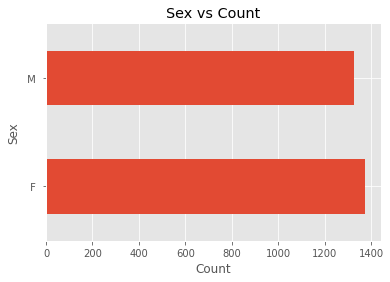

In [225]:
df['target'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Sex')
plt.title('Sex vs Count')

# Data Preparation


## Encoding

Since our task is the solving gender classification problem, our model's target value will be the sex which is indicated as column of `sex` in dataframe. `sex` column comprised of two different string values which are `F` for female, and `M` for male. Usually, in Deep Learning models we want to use numerical data only, therefore we should replace these string values with integers; `1` for male and `0` for female. This operation called 'encoding' in deep learning field and in order to implement encoding we are going to use `LabelEncoder()`function from `sklearn`'s `preprocessing` class.

In [20]:
from sklearn.preprocessing import LabelEncoder

# Encode the classification target 'sex'
# Male: 1, Female: 0
le = LabelEncoder()
df['target'] = le.fit_transform(df.target.values)
# Check a few records to make sure its processed successfully
df.head()

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,1,-326.910417,118.246153,-3.947102,46.341876,-29.798891,28.969367,-18.378240,8.611159,-4.771251,-3.890529,6.524523,-2.921271,8.750445,-8.307909,15.937849,-3.796074,-1.210859,-1.452906,-2.223367,0.787522,-4.797419,0.538821,-8.273893,3.131577,-3.345540,-0.961538,-0.597462,-3.303950,-0.752606,-5.294038,-2.039995,-1.470875,0.258924,-3.935838,-3.567904,-2.474241,-0.393718,-1.236598,-2.318787,-2.425744
1,1,-315.703845,106.690190,-2.009781,37.753394,-13.557173,32.247902,-19.279778,1.423161,-3.585404,-2.511189,6.179291,-6.094820,7.370222,-5.499543,12.013534,-1.332932,-2.307119,-3.077107,-3.071591,0.736987,-5.694947,-0.444205,-6.922916,0.568421,-2.965757,-2.203856,-3.129249,-5.129259,-1.122419,-4.896270,-1.978233,-1.843360,-0.528067,-3.171499,-2.980504,-0.730151,-0.600699,-1.707380,-2.264171,-1.959905
2,1,-314.356694,94.172639,-4.345592,47.050117,-18.286299,30.831474,-19.778252,5.545323,-5.471066,-6.489484,6.024238,-7.201951,8.457216,-6.725968,11.540727,-2.725252,-2.501616,-2.089313,-3.411918,0.187875,-5.974069,0.927543,-7.692077,1.346849,-1.596855,-2.697115,-1.692692,-4.436242,-0.875936,-4.130971,-1.503375,-0.789004,0.013868,-2.105496,-2.868169,-2.372312,-0.867878,-1.530756,-2.289539,-1.829164
3,1,-315.949393,110.483959,-1.855775,36.924015,-10.350659,27.413701,-20.056152,1.725721,-3.406663,-3.580545,3.452538,-5.469242,9.367549,-7.281216,9.091121,0.074574,-1.556631,-1.835865,-1.191415,-0.106927,-5.562501,0.556109,-6.683795,2.531428,-1.768993,-2.017375,-1.913903,-4.184221,-2.456464,-6.901672,-0.559045,-1.301393,-0.665764,-2.549356,-3.866826,-1.808462,-2.016617,-2.438014,-1.911034,-2.080636
4,1,-317.010667,94.074392,0.214325,35.943011,-15.323959,29.635318,-19.840273,2.348713,-1.968008,-3.662814,7.932648,-6.901921,6.597340,-7.214306,7.309999,0.257246,-2.294690,-3.217468,-1.311037,0.343210,-6.558946,1.253608,-6.533683,0.250248,-1.930332,-3.091149,-1.142776,-3.355388,-1.864002,-3.599445,-0.299018,-2.075663,-0.084519,-1.738023,-1.994926,-1.204233,-2.003319,-1.552478,-2.498971,-1.541701


## Splitting Data into Training and Test Sets

While building real world machine learning models, it is quite common to split the dataset into 2 parts:

*   Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
*   Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.




In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1),  # Features
                                                    df.target,    # Targets
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=42
                                                    )
X_train[0:5]

## Feature Scaling

Many models use some form of distance to inform them i.e. k-NN uses distance explicitly when making predictions. Since features on larger scales can unduly inﬂuence the model, we want features to be on a similar scale therefore we are applying scaling function to our data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.fit_transform(X_test.values)
# Lets see how the data present itself after normalisation 
X_train[0:5]

# Machine Learning Classifiers

## KNN Model

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

steps = [('scaler', StandardScaler()),  # Scale the input data
         ('knn', KNeighborsClassifier())]  # Apply classifier

pipe_knn  = Pipeline(steps)  # Create a pipeline

param_range = [3, 5, 7, 9, 11, 13]  # Parameter range to be tried as KNN's number of neighbors 
param_grid = {'knn__n_neighbors': param_range,
              'knn__weights': ['uniform', 'distance'],
              'knn__metric': ['euclidean', 'manhattan']}

# Apply grid search for trying different parameters and find the best ones
cv_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    scoring='accuracy',  # Accuracys as metric
    cv=10,  # K-Folds cross validation k:10
)

cv_knn.fit(X_train, y_train)  # Fit the model
knn_score = cv_knn.score(X_test, y_test)
y_pred = cv_knn.predict(X_test)  # Predict

print("Best parameters for KNN: ", cv_knn.best_params_)
print("\nBest score: ", cv_knn.best_score_)
print("\nTest accuracy: %.4f" % knn_score )
print("\nConfusion matrix: ", confusion_matrix(y_test, y_pred))
print("\nClassification report: ", classification_report(y_test, y_pred))

Best parameters for KNN:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

Best score:  0.9965198405164231

Test accuracy: 0.9975

Confusion matrix:  [[216   0]
 [  1 189]]

Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      0.99      1.00       190

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406



## SVM Model

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

steps = [('scaler', StandardScaler()),  # Scale the input data
         #('pca', PCA(n_components=10)),
         ('svc', SVC(random_state=42))]  # Apply classifier

pipe_svc  = Pipeline(steps)  # Create a pipeline

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]  # Parameter range to be tried as SVM's C and gama values
param_grid = {'svc__C': param_range,
              'svc__gamma': param_range,
              'svc__kernel': ['linear', 'rbf']}

# Apply grid search for trying different parameters and find the best ones
cv_svc = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',  # Accuracys as metric
    cv=10,  # K-Folds cross validation k:5
)

cv_svc.fit(X_train, y_train)  # Fit the model
svc_score = cv_svc.score(X_test, y_test)
y_pred = cv_svc.predict(X_test)  # Predict

print("Best parameters for SVC: ", cv_svc.best_params_)
print("\nBest score: ", cv_svc.best_score_)
print("\nTest Accuracy: %.4f" % svc_score)
print("\nConfusion matrix: ", confusion_matrix(y_test, y_pred))
print("\nClassification report: ", classification_report(y_test, y_pred))

Best parameters for SVC:  {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Best score:  0.9943421302449214

Test Accuracy: 0.9926

Confusion matrix:  [[215   1]
 [  2 188]]

Classification report:                precision    recall  f1-score   support

           0       0.99      1.00      0.99       216
           1       0.99      0.99      0.99       190

    accuracy                           0.99       406
   macro avg       0.99      0.99      0.99       406
weighted avg       0.99      0.99      0.99       406



# Deep Learning Classifiers

In [226]:
def predict(model, X_test):
  y_pred = model.predict(X_test)
  y_pred[y_pred <= 0.5] = 0.
  y_pred[y_pred > 0.5] = 1.
  return y_pred

In [229]:
def plot_confusion_matrix(y_test, y_pred):
  """
  Plots confusion matrix.
  """
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
  plt.xlabel('Actual Label')
  plt.ylabel('Predicted Label')

In [230]:
def plot_loss_accuracy(history):
  """
  Plots loss vs epoch and accuracy vs epoch graphs.
  """
  plt.figure(figsize=(10, 5))  # Create a figure and set figure size
  plt.title('Model Loss vs Epoch')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.plot(history.history['loss'])
  plt.show()

  # Plot Accuracy vs Epoch
  plt.figure(figsize=(10, 5))  # Create a figure and set figure size
  plt.title('Model Accuracy vs Epoch')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.plot(history.history['accuracy'])
  plt.show()

## Logistic Regression Model

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import regularizers


In [27]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(2297, 40, 1)

In [28]:
lr_model = Sequential()
lr_model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1], 1)))
lr_model.add(Dropout(0.2))

lr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40, 1)             2         
_________________________________________________________________
dropout (Dropout)            (None, 40, 1)             0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [63]:
lr_model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.SGD(lr=0.0001), 
    metrics=['accuracy']
)

lr_history = lr_model.fit(
    X_train, 
    y_train, 
    batch_size=128, 
    epochs=10, 
    shuffle=True,
)

Epoch 1/10
18/18 [==============================] - 0s 3ms/step - loss: 2.0733 - accuracy: 0.5487
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 2.0821 - accuracy: 0.5510
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 2.0872 - accuracy: 0.5491
Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 2.0824 - accuracy: 0.5494
Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 2.0639 - accuracy: 0.5508
Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 2.0624 - accuracy: 0.5517
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 2.0723 - accuracy: 0.5492
Epoch 8/10
18/18 [==============================] - 0s 3ms/step - loss: 2.0603 - accuracy: 0.5506
Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 2.0873 - accuracy: 0.5503
Epoch 10/10
18/18 [==============================] - 0s 2ms/step - loss: 2.0655 - accuracy: 0.5510


In [64]:
lr_score = lr_model.evaluate(x=X_test, y=y_test)[1]  # Evaluate on test data

13/13 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5546


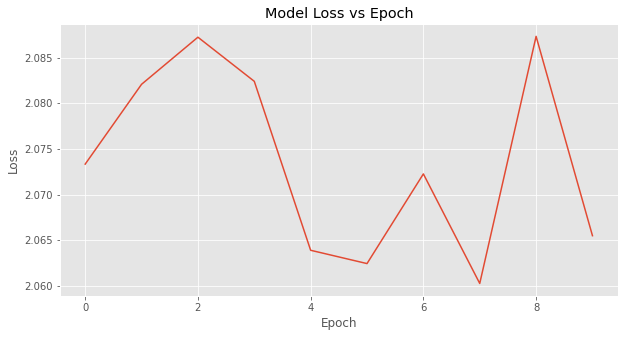

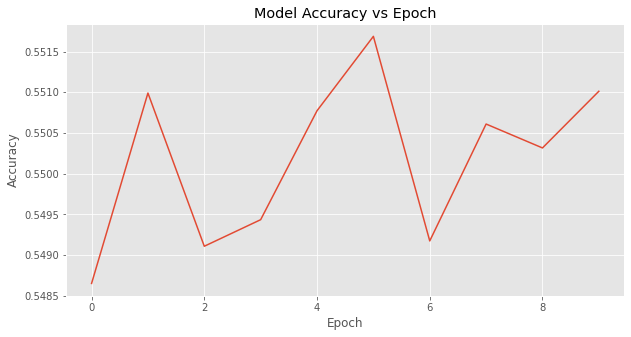

In [102]:
plot_loss_accuracy(lr_history)

This model of Logistic Regression was quite poor, giving accuracies around 55% on training data and 55% on test data. Clearly, the network wasn't overﬁtting however the accuracy and the loss values were almost constant, didn't change a lot. Adding L1, L2 and dropout regularizers did not seem to help with the problem. Logistic Regression algorithm was unable to extract pattern of male and female speeches.

## ANN

In [32]:
# ANN architecture
ann_model = Sequential()
# First Dense layer
ann_model.add(Dense(64, input_shape=(X_train.shape[1], 1)))
ann_model.add(Activation('relu'))
# Second Dense layer
ann_model.add(Dense(128))
ann_model.add(Activation('relu'))
# Third Dense layer
ann_model.add(Dense(256))
ann_model.add(Activation('relu'))
# Fourth Dense layer
ann_model.add(Dense(128))
ann_model.add(Activation('relu'))
# Fifth Dense layer
ann_model.add(Dense(64))
ann_model.add(Activation('relu'))
ann_model.add(Dropout(0.3))
# Output Dense layer
ann_model.add(Dense(1))
ann_model.add(Activation('sigmoid'))

ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40, 64)            128       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 40, 128)           8320      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 40, 256)           33024     
_________________________________________________________________
activation_2 (Activation)    (None, 40, 256)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 40, 128)          

In [33]:
ann_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

ann_history = ann_model.fit(
    X_train,
    y_train, 
    batch_size=128, 
    epochs=25,
    shuffle=True,
)

Epoch 1/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5342
Epoch 2/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6870 - accuracy: 0.5613
Epoch 3/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6826 - accuracy: 0.5654
Epoch 4/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6787 - accuracy: 0.5713
Epoch 5/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6793 - accuracy: 0.5709
Epoch 6/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6784 - accuracy: 0.5728
Epoch 7/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6786 - accuracy: 0.5729
Epoch 8/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6787 - accuracy: 0.5714
Epoch 9/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6781 - accuracy: 0.5718
Epoch 10/25
18/18 [==============================] - 0s 7ms/step - loss: 0.6786 - accuracy: 0.5719
Epoch 11/25
18/18 [

In [34]:
ann_score = ann_model.evaluate(x=X_test, y=y_test)[1]  # Evaluate on test data

13/13 [==============================] - 0s 4ms/step - loss: 0.6699 - accuracy: 0.5986


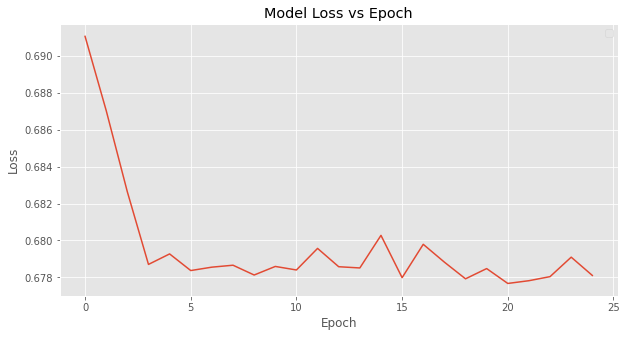

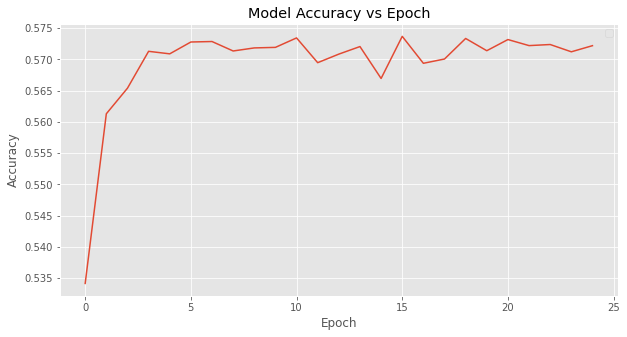

In [35]:
plot_loss_accuracy(ann_history)

This setup of artificial neural network was quite poor, giving accuracies around 57% on training data and 59% on test data. Clearly, the network wasn't overﬁtting however the accuracy wasn't improving as expected. Training started stable; while loss value is decreasing accuracy was increasing. However, model stucked at certain local minima point. Adding more layers or neurons and tuning hyper parameters such as learning rate and number of epochs did not seem to help with the problem. Adding L1, L2 and dropout regularizers did not help either. As a result, ANN algorithm was unable to extract pattern of male and female speeches.

## LSTM Based RNN Model

In [137]:
from keras.layers import Bidirectional, Embedding, LSTM, GRU

# The LSTM architecture
lstm_model = Sequential()
lstm_model.add(BatchNormalization(momentum=0.89, input_shape=(X_train.shape[1], 1)))
# First LSTM layer
lstm_model.add(Bidirectional(LSTM(512, return_sequences = True)))
lstm_model.add(Dropout(0.5))
# Flatten layer
lstm_model.add(Flatten())
# First Dense layer
lstm_model.add(Dense(64))
lstm_model.add(Activation('relu'))
# Second Dense layer
lstm_model.add(Dense(16))
lstm_model.add(Activation('relu'))
# Third and output Dense layer
lstm_model.add(Dense(1, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
lstm_model.add(Activation('sigmoid'))
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_40 (Batc (None, 40, 1)             4         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 40, 1024)          2105344   
_________________________________________________________________
dropout_27 (Dropout)         (None, 40, 1024)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 40960)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                2621504   
_________________________________________________________________
activation_45 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)              

In [129]:
lstm_model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=0.0001), 
    metrics=['accuracy']
)

lstm_history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=50, 
)

Epoch 1/50
18/18 [==============================] - 1s 36ms/step - loss: 0.5221 - accuracy: 0.7423
Epoch 2/50
18/18 [==============================] - 1s 31ms/step - loss: 0.3719 - accuracy: 0.8337
Epoch 3/50
18/18 [==============================] - 1s 31ms/step - loss: 0.3044 - accuracy: 0.8698
Epoch 4/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2545 - accuracy: 0.8912
Epoch 5/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2210 - accuracy: 0.9155
Epoch 6/50
18/18 [==============================] - 1s 31ms/step - loss: 0.2034 - accuracy: 0.9203
Epoch 7/50
18/18 [==============================] - 1s 31ms/step - loss: 0.1912 - accuracy: 0.9234
Epoch 8/50
18/18 [==============================] - 1s 31ms/step - loss: 0.1773 - accuracy: 0.9356
Epoch 9/50
18/18 [==============================] - 1s 31ms/step - loss: 0.1683 - accuracy: 0.9351
Epoch 10/50
18/18 [==============================] - 1s 31ms/step - loss: 0.1619 - accuracy: 0.9382
Epoch 11/

In [130]:
lstm_score = lstm_model.evaluate(x=X_test, y=y_test)[1]  # Evaluate on test data

13/13 [==============================] - 0s 5ms/step - loss: 0.0367 - accuracy: 0.9828


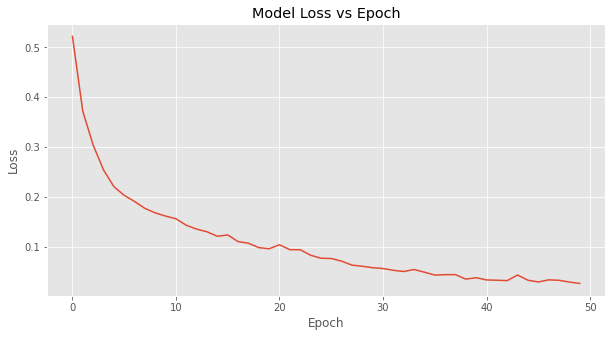

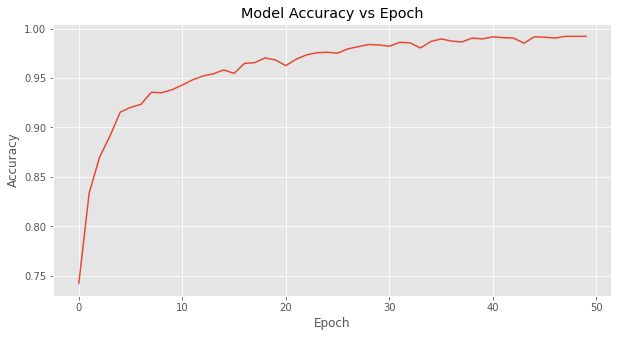

In [131]:
plot_loss_accuracy(lstm_history)

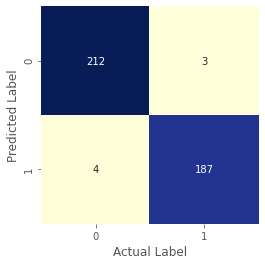

In [132]:
y_pred = predict(lstm_model, X_test)
plot_confusion_matrix(y_test, y_pred)

Since our data is speech data which is a time series, my first intuition was that the LSTM based RNN would give tremendous advantage compared the other algorithms because RNNs known with their great performances on time series data such as audio or text. And it worked as I expected. This setup of LSTM based RNN was giving accuracies around 99% on training data and 98% on test data. The model was very stable and it succesfully found the pattern of dataset.

## CNN Model

In [72]:
# The CNN architecture
cnn_model = Sequential()
# First Conv layer
cnn_model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1], 1))) 
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling1D(padding='same'))
# Second Conv layer
cnn_model.add(Conv1D(256, 3, padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling1D(padding='same'))
# Third Conv layer
cnn_model.add(Conv1D(128, 3, padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling1D(padding='same'))
# Third Conv layer
cnn_model.add(Conv1D(128, 3, padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling1D(padding='same'))
# Third Conv layer
cnn_model.add(Conv1D(64, 5, padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling1D(padding='same'))
# Fourth Conv layer
cnn_model.add(Conv1D(64, 3, padding='same', kernel_regularizer='l2'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(AveragePooling1D(padding='same'))
# Flatten layer
cnn_model.add(Flatten())
# First and output Dense layer
cnn_model.add(Dense(1, kernel_regularizer='l2'))
cnn_model.add(Activation('sigmoid'))
cnn_model.add(Dropout(0.3))
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 40, 512)           3072      
_________________________________________________________________
batch_normalization_19 (Batc (None, 40, 512)           2048      
_________________________________________________________________
activation_30 (Activation)   (None, 40, 512)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 20, 512)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 20, 256)           393472    
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 256)          

In [75]:
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.0001),
    metrics=['accuracy'],
)

cnn_history = cnn_model.fit(
    X_train,
    y_train, 
    batch_size=128, 
    epochs=50, 
)

Epoch 1/50
18/18 [==============================] - 0s 15ms/step - loss: 2.9909 - accuracy: 0.8150
Epoch 2/50
18/18 [==============================] - 0s 12ms/step - loss: 2.7683 - accuracy: 0.8354
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 2.8223 - accuracy: 0.8380
Epoch 4/50
18/18 [==============================] - 0s 12ms/step - loss: 2.6902 - accuracy: 0.8502
Epoch 5/50
18/18 [==============================] - 0s 12ms/step - loss: 2.9125 - accuracy: 0.8376
Epoch 6/50
18/18 [==============================] - 0s 12ms/step - loss: 2.8155 - accuracy: 0.8402
Epoch 7/50
18/18 [==============================] - 0s 12ms/step - loss: 2.6653 - accuracy: 0.8515
Epoch 8/50
18/18 [==============================] - 0s 11ms/step - loss: 2.8360 - accuracy: 0.8424
Epoch 9/50
18/18 [==============================] - 0s 11ms/step - loss: 2.6230 - accuracy: 0.8537
Epoch 10/50
18/18 [==============================] - 0s 11ms/step - loss: 2.7716 - accuracy: 0.8450
Epoch 11/

In [76]:
cnn_score = cnn_model.evaluate(x=X_test, y=y_test)[1]  # Evaluate on test data

13/13 [==============================] - 0s 3ms/step - loss: 0.1493 - accuracy: 0.9951


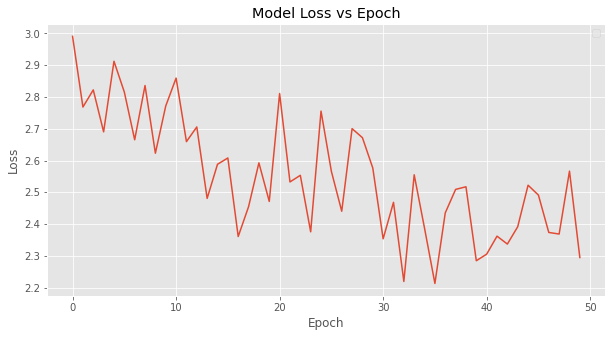

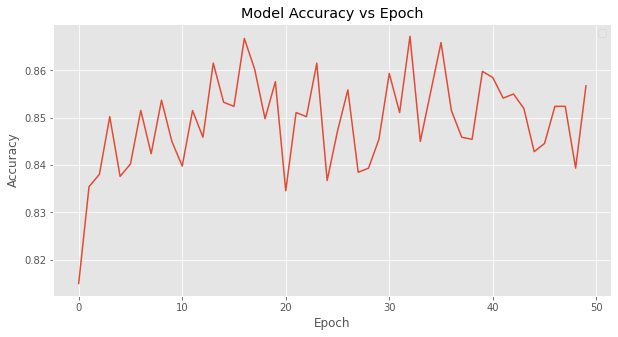

In [77]:
# Plot Loss vs Epoch
plot_loss_accuracy(cnn_history)

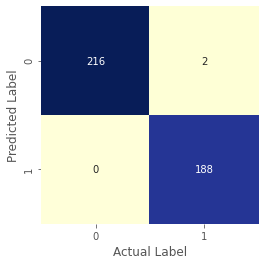

In [126]:
y_pred = predict(cnn_model, X_test)
plot_confusion_matrix(y_test, y_pred)

CNN is very powerful algorithm that performs well with particularly image classification tasks and it is able extract high quality feautures from data itself thanks to convolution layers. I thought that this will be very effective at finding patterns within the MFCC’s much like they are effective at finding patterns within images.

* Each successive layer of convolutions and pooling extracts relevant        frequency patterns at a successively higher level of abstraction, analogous to a 2D image classifier's features extraction.

* At the final layer we apply a global max pooling over the time dimension to find the highest value of each filter. My intuition is this will help the model ignore irrelevant time periods such as silence or noise and focus on information from relevant periods.

* Combine these features via a fully connected layer to form the prediction.

As I expected, the CNN algorithm worked pretty well. Obviously, CNN model outperformed the Logistic Regression and ANN model. This setup of CNN was giving accuracies around 85% on training data and 99% on test data. Eventhough it seem relatively succesfull, model was quite unstable during experimenting, test accuracy flactuated between 83% and 86% which makes it unstable.

## CNN + GRU Model

In [133]:
# CNN+GRU architecture
cnn_gru_model = Sequential()
cnn_gru_model.add(BatchNormalization(axis=-1, momentum=0.89, epsilon=1e-3, center=True, scale=True, input_shape=(X_train.shape[1], 1)))
# First Conv1D layer
cnn_gru_model.add(Conv1D(8, 13, padding='same', activation='relu', strides=1))
cnn_gru_model.add(MaxPooling1D(3, padding='same'))
cnn_gru_model.add(Dropout(0.3))
# Second Conv1D layer
cnn_gru_model.add(Conv1D(16, 11, padding='same', activation='relu', strides=1))
cnn_gru_model.add(MaxPooling1D(3, padding='same'))
cnn_gru_model.add(Dropout(0.3))
# Third Conv1D layer
cnn_gru_model.add(Conv1D(32, 9, padding='same', activation='relu', strides=1))
cnn_gru_model.add(MaxPooling1D(3, padding='same'))
cnn_gru_model.add(Dropout(0.3))
# Bidirectional GRU layers
cnn_gru_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True))
cnn_gru_model.add(Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
cnn_gru_model.add(Bidirectional(GRU(128, return_sequences=True), merge_mode='sum'))
cnn_gru_model.add(Bidirectional(GRU(128, return_sequences=False), merge_mode='sum'))
cnn_gru_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True))
# Flatten layer
cnn_gru_model.add(Flatten())
# First Dense Layer
cnn_gru_model.add(Dense(256))
cnn_gru_model.add(Activation('relu'))
# Second and output Dense Layer
cnn_gru_model.add(Dense(1))
cnn_gru_model.add(Activation('sigmoid'))
cnn_gru_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_37 (Batc (None, 40, 1)             4         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 40, 8)             112       
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 14, 8)             0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 8)             0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 14, 16)            1424      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 5, 16)             0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 16)           

In [134]:
cnn_gru_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=0.0001),
    metrics=['accuracy'],
)

cnn_gru_history = cnn_gru_model.fit(
    X_train,
    y_train, 
    batch_size=128, 
    epochs=50, 
)

Epoch 1/50
18/18 [==============================] - 0s 13ms/step - loss: 0.6394 - accuracy: 0.6226
Epoch 2/50
18/18 [==============================] - 0s 12ms/step - loss: 0.5512 - accuracy: 0.7166
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 0.5295 - accuracy: 0.7410
Epoch 4/50
18/18 [==============================] - 0s 12ms/step - loss: 0.5004 - accuracy: 0.7523
Epoch 5/50
18/18 [==============================] - 0s 12ms/step - loss: 0.4789 - accuracy: 0.7584
Epoch 6/50
18/18 [==============================] - 0s 13ms/step - loss: 0.4741 - accuracy: 0.7788
Epoch 7/50
18/18 [==============================] - 0s 12ms/step - loss: 0.4618 - accuracy: 0.7906
Epoch 8/50
18/18 [==============================] - 0s 12ms/step - loss: 0.4390 - accuracy: 0.7928
Epoch 9/50
18/18 [==============================] - 0s 12ms/step - loss: 0.4284 - accuracy: 0.8089
Epoch 10/50
18/18 [==============================] - 0s 13ms/step - loss: 0.4256 - accuracy: 0.8119
Epoch 11/

In [135]:
cnn_gru_score = cnn_gru_model.evaluate(x=X_test, y=y_test)[1]  # Evaluate on test data

13/13 [==============================] - 0s 5ms/step - loss: 0.2070 - accuracy: 0.9089


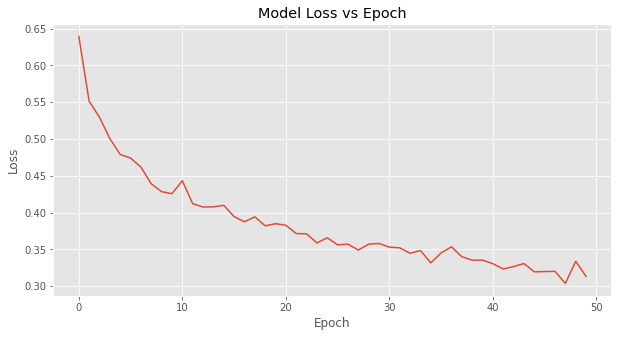

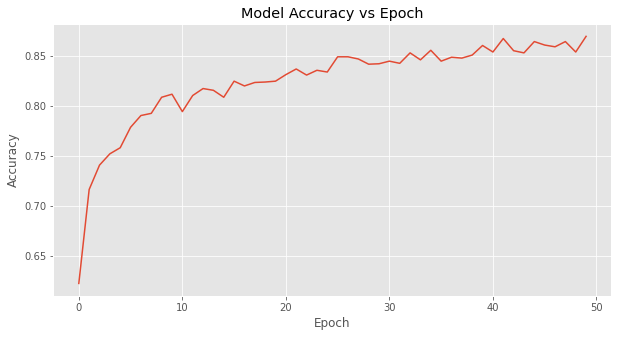

In [136]:
plot_loss_accuracy(cnn_gru_history)

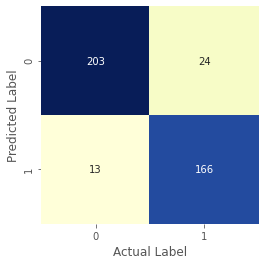

In [138]:
y_pred = predict(cnn_gru_model, X_test)
plot_confusion_matrix(y_test, y_pred)

# Comparasion

In [140]:
print("KNN model's accuracy: %.2f%%" % knn_score)
print("SVM model's accuracy: %.2f%%" % svc_score)
print("Logistic Regression model's accuracy: %.2f%%}" % (lr_score*100))
print("ANN model's accuracy: %.2f%%" % (ann_score*100))
print("LSTM based RNN model's accuracy: %.2f%%" % (lstm_score*100))
print("CNN model's accuracy: %.2f%%" % (cnn_score*100))
print("CNN+GRU model's accuracy: %.2f%%" % (cnn_gru_score*100))

KNN model's accuracy: 1.00%
SVM model's accuracy: 0.99%
Logistic Regression model's accuracy: 55.46%}
ANN model's accuracy: 59.86%
LSTM based RNN model's accuracy: 98.28%
CNN model's accuracy: 99.51%
CNN+GRU model's accuracy: 90.89%


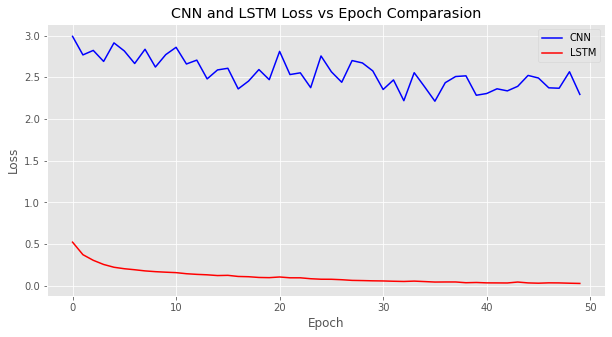

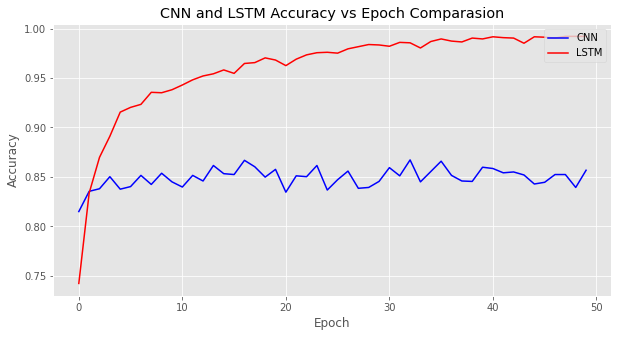

In [144]:
# Plot Loss vs Epoch
plt.figure(figsize=(10, 5))  # Create a figure and set figure size
plt.title('CNN and LSTM Loss vs Epoch Comparasion')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(cnn_history.history['loss'], "-b", label="CNN")
plt.plot(lstm_history.history['loss'], "-r", label="LSTM")
plt.legend(loc='upper right')
plt.show()

# Plot Accuracy vs Epoch
plt.figure(figsize=(10, 5))  # Create a figure and set figure size
plt.title('CNN and LSTM Accuracy vs Epoch Comparasion')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(cnn_history.history['accuracy'], "-b", label="CNN")
plt.plot(lstm_history.history['accuracy'], "-r", label="LSTM")
plt.legend(loc='upper right')
plt.show()

At first glance CNN and LSTM models seem give similar performance since they both have 99% accuracy on test data. Above I made a comparasion of CNN and LSTM models to see training process of these two model. Clearly, CNN model has got an unstable process of training compared to LSTM model.

To conclude up: in all of these different models, it is obvious that LSTM based RNN mobel is the better one along with the KNN and SVM. SVM and KNN models have got a bit longer training time compared to LSTM model.

In [45]:
# Save model, weights and state of the optimizer
model_name = 'gender_classification_lstm.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
lstm_model.save(model_path)
print("Save model and weights at %s " % model_path)

Save model and weights at /content/saved_models/gender_classification_lstm.h5 


In [46]:
best_model = load_model('saved_models/gender_classification_lstm.h5')
print("Loaded model from disk.")

Loaded model from disk.


# Resources

* https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data
* https://www.kaggle.com/hamditarek/audio-data-analysis-using-librosa
* https://www.kaggle.com/davids1992/speech-representation-and-data-exploration
* https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7